In [1]:
%matplotlib inline
from matplotlib import style
from pandas.plotting import table
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement= Base.classes.measurement
Station= Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

In [8]:
##Find the latest_date ----------------> ('2017-08-23')
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [9]:
##Assign period range to query
query_period=(dt.date(2017,8,23))-dt.timedelta(days=365)
print("Query Date: ", query_period, " to ", latest_date)

Query Date:  2016-08-23  to  ('2017-08-23',)


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_table=session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date>=query_period).\
                    order_by(Measurement.date).all()
measurement_table


[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df =pd.DataFrame(measurement_table)

measurement_df.set_index('date', inplace=True)
measurement_df.head(4)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN


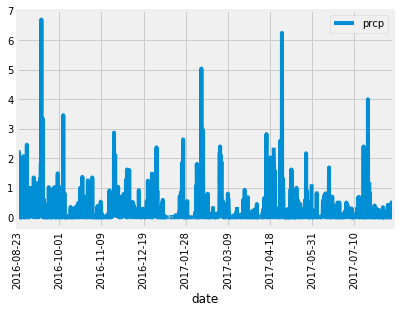

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(rot=90)
plt.show
plt.savefig('precipitation.png')


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


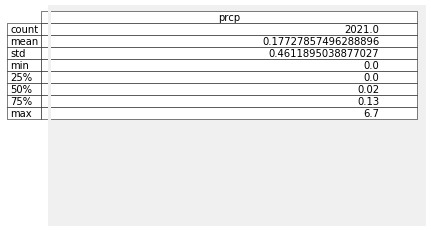

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_desc=measurement_df['prcp'].describe()


# #create a subplot without frame
plot = plt.subplot(111, frame_on=True)

# #remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

# #create the table plot and position it in the upper left corner
table(plot, measurement_desc,loc='upper right')



# Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()
# session.query(func.count(distinct(station.station)))   ----check with yi fu why the distinct function doesn't work 

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = [Measurement.station,
         func.count(Measurement.station)]
active_stations = session.query(*stations).\
   group_by(Measurement.station).\
   order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

## Assign variable for top station
top_station=active_stations[0][0]

tobs= [func.min(Measurement.tobs), 
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

tobs_analysis=session.query(*tobs).\
            filter(Measurement.station==top_station).all()
tobs_analysis

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

 #-query_period variable from the Precipitation Analysis section from the top
query_tobs=session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station==top_station).\
            filter(Measurement.date>=query_period).all() 

In [19]:
# Save the query results as a Pandas DataFrame 
tobs_df=pd.DataFrame(query_tobs)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


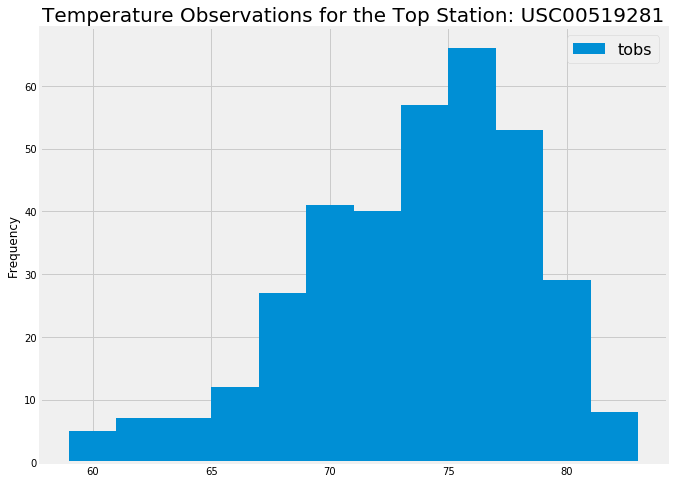

In [20]:
# plot the retuls as a histogram wiht Bin=12
tobs_df.plot.hist(by='station', bins=12, figsize=(10,8))
plt.title("Temperature Observations for the Top Station: " +top_station, fontsize=20)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.show
plt.savefig('station-histogram.png')

# Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    selection_result=session.query(func.min(Measurement.tobs), 
                                   func.avg(Measurement.tobs), 
                                   func.max(Measurement.tobs)).\
                                filter(Measurement.date >= start_date).\
                                filter(Measurement.date <= end_date).all()
    return selection_result
 
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temCal=calc_temps('2017-01-01', '2018-01-01')
trip_temCal

[(58.0, 74.14387974230493, 87.0)]

In [23]:
# Save the query results as a Pandas DataFrame 
trip_df=pd.DataFrame(trip_temCal, columns=['tmin', 'tavg', 'tmax'])
trip_df

,tmin,tavg,tmax
0,58.0,74.14388,87.0


In [24]:
#Assign variables for tavg, and tmin_tmax
tavg = trip_df['tavg']
tmin_tmax = trip_df.iloc[0]['tmax'] - trip_df.iloc[0]['tmin']

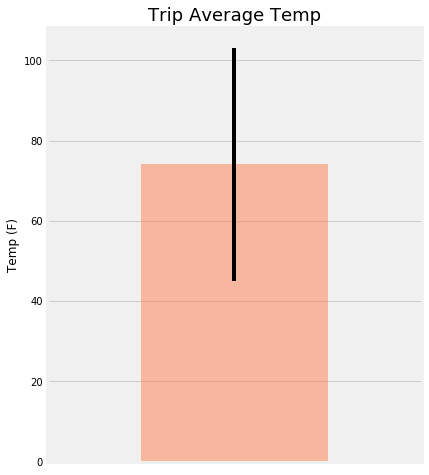

<Figure size 432x288 with 0 Axes>

In [25]:
# plot the retuls into bar chart
tavg .plot(kind='bar', yerr=tmin_tmax, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Average Temp", fontsize=18)
plt.ylabel("Temp (F)")
plt.xticks([])

plt.show()
plt.savefig('temperature.png')